In [1]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
path_file = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/mc_361106.Zee.1largeRjet1lep.root'

In [3]:
data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
tree = uproot3.open(path_file)["mini"] # open the tree called mini
numevents = uproot3.numentries(path_file, "mini") # number of events
print("Number of events: ", numevents)

Number of events:  53653


In [4]:
fraction = 1.0

In [5]:
def calc_mll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    sumpx = px_0 + px_1 # x-component of momentum
    sumpy = py_0 + py_1 # y-component of momentum
    sumpz = pz_0 + pz_1 # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

In [6]:
def cut(lep_n,lep_charge,lep_type):    
    cuts = False
    # Cut #1: At least 2 leptons
    if lep_n >= 2:
        
        # Cut #2: Leptons with opposite charge
        if (lep_charge[0] != lep_charge[1]):
            
            # Cut #3: Leptons of the same family (2 electrons or 2 muons)
            if (lep_type[0] == lep_type[1]):
                
                # Let's define one TLorentz vector for each, e.i. two vectors!
                #leadLepton.SetPtEtaPhiE(lep_pt[0]/1000., lep_eta[0], lep_phi[0], lep_E[0]/1000.)
                #trailLepton.SetPtEtaPhiE(lep_pt[1]/1000., lep_eta[1], lep_phi[1], lep_E[1]/1000.)
                # Next line: addition of two TLorentz vectors above --> ask mass very easy (devide by 1000 to get value in GeV)
                #invmass = leadLepton + trailLepton
                cuts = True
                #hist.Fill(invmass.M())
                
    return cuts==True

In [7]:
for data in tree.iterate(["lep_n","lep_charge","lep_type","lep_pt",
                        "lep_phi","lep_eta","lep_E"], # add more variables here if you want to use them
                        outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                        entrystop=numevents*fraction): # process up to numevents*fraction
    nIn = len(data.index) # number of events in this batch
    
    # Cuts applied in the function cut
    data = data[ np.vectorize(cut)(data.lep_n,data.lep_charge,data.lep_type)]
    
    # Calculate reconstructed dilepton invariant mass using the function calc_mll defined above
    data['mll'] = np.vectorize(calc_mll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
    nOut = len(data.index) # number of events passing cuts in this batch
    print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after
    data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
    
data_all

	 nIn: 53653,	 nOut: 	37415


/tmp/ipykernel_1486/3643191596.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mll'] = np.vectorize(calc_mll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)


,lep_n,lep_charge,lep_type,lep_pt,lep_phi,lep_eta,lep_E,mll
entry,,,,,,,,
0,2,"[1, -1]","[11, 11]","[169903.48, 142998.28]","[3.0199232, -2.9465997]","[-1.8025961, -1.29893]","[529270.06, 281577.66]",93.331829
1,2,"[-1, 1]","[11, 11]","[211820.23, 78281.89]","[-3.0646539, 2.5374086]","[0.047025315, -0.12980008]","[212054.48, 78942.266]",88.992615
2,2,"[1, -1]","[11, 11]","[234039.14, 8108.9414]","[-2.36613, -0.6087628]","[0.5145523, -0.5389483]","[265711.38, 9315.408]",82.511479
3,2,"[-1, 1]","[11, 11]","[282535.56, 60798.965]","[-2.322139, -1.9640917]","[-0.15060467, -0.712555]","[285745.8, 76898.055]",88.020261
4,2,"[-1, 1]","[11, 11]","[193694.88, 135181.3]","[-1.3102051, -1.2278727]","[0.43973032, -0.09355457]","[212725.27, 135773.31]",88.329252
...,...,...,...,...,...,...,...,...
53646,2,"[1, -1]","[11, 11]","[245795.55, 222063.52]","[2.5181298, 2.6780536]","[0.12005247, -0.23323603]","[247568.95, 228130.97]",90.976538
53647,2,"[-1, 1]","[11, 11]","[264119.16, 29385.602]","[-0.56256586, -0.42886025]","[0.5077818, -0.1588098]","[298907.66, 29756.941]",60.965821
53649,2,"[-1, 1]","[11, 11]","[188751.66, 24947.594]","[0.45541525, -0.84419966]","[1.8628806, 1.3455658]","[622643.8, 51151.938]",90.463155


In [8]:
def plot_data():   

    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data_all['mll'], 
                            bins=bin_edges ) # histogram the data
    #plt.hist(data_all['mll'], # background in train set
     #        bins=bin_edges, # lower and upper range of the bins
      #       density=True, # area under the histogram will sum to 1
       #      histtype='stepfilled', # lineplot that's filled
        #     color='red', label='Data', # Background (train)
         #   alpha=0.5 ) # half transparency    
    
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                      fmt='ko', # 'k' means black and 'o' means circles
                      label='Data' ) 

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.1, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.1, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    #lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.1, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.1, # x
             0.74, # y
             r'$Z \rightarrow e^{+}e^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    # 'upper left', 'upper right', 'lower left', 'lower right'
    main_axes.legend(frameon=True, # no box around the legend
                     loc='upper right' ) # legend location 
    
    # x-axis label
    plt.xlabel(r'di-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]')
    
    # y-axis label
    plt.ylabel('Events')

    plt.xticks(np.arange(xmin, xmax, step=10))
    
    plt.title('Mass of the Z boson')
    return

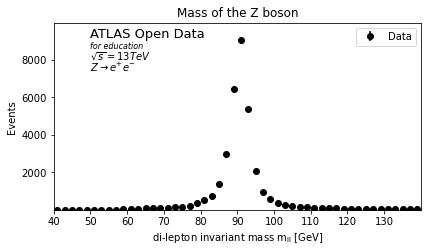

In [9]:
plot_data()

In [27]:
def plot_2():

    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values    
    
    plt.hist(data_all['mll'], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             #density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                      fmt='ko', # 'k' means black and 'o' means circles
                      label='Data' )     
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 
    
    # Add text 'ATLAS Open Data' on plot
    plt.text(0.1, # x
             5.92, # y
             'ATLAS Open Data', # text
             #transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.1, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    #lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.1, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.3, # x
             1.74, # y
             r'$Z \rightarrow e^{+}e^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    plt.xlabel("BDT output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    

NameError: name 'data_x' is not defined

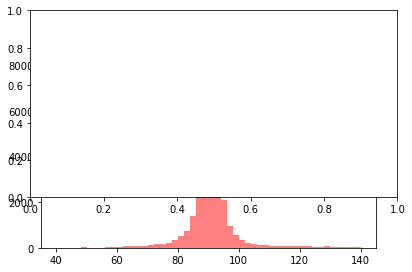

In [28]:
plot_2()